# Data Science Project Tutorial

A growing list of public APIs with JSON data

[The List](https://github.com/toddmotto/public-apis)


In [2]:
import json
import calendar
import random
from datetime import date, timedelta
import numpy as np
from pandas import DataFrame
import pandas as pd

# 3rd Party modules (not part of Anaconda)
from delorean import parse
import faker

In [3]:
fake = faker.Faker()

usernames = set()
usernames_no = 1000

while len(usernames) < usernames_no:
    usernames.add(fake.user_name())

In [4]:
def get_random_name_and_gender():
    skew = .6 # 60% of users will be female
    male = random.random() > skew
    if male:
        return fake.name_male(), 'M'
    else:
        return fake.name_female(), 'F'
    
def get_users(usernames):
    users = []
    for username in usernames:
        name, gender = get_random_name_and_gender()
        user = {
            'username': username,
            'name': name,
            'gender': gender,
            'email': fake.email(),
            'age': fake.random_int(min=18, max=90),
            'address': fake.address(),
        }
        users.append(json.dumps(user))
    return users

In [5]:
# each username now a user dict then dumped to JSON, added to list
users = get_users(usernames)
users[:3]

['{"username": "lauriepowell", "name": "Karina Jones", "gender": "F", "email": "amanda50@cohen.net", "age": 77, "address": "60108 Lawrence Cove Suite 372\\nThompsonhaven, OK 51120"}',
 '{"username": "phillipstami", "name": "Melissa Johnson", "gender": "F", "email": "susanrodriguez@hotmail.com", "age": 70, "address": "02212 Lisa Estates Suite 968\\nMorrisburgh, MP 74969"}',
 '{"username": "ymorrison", "name": "Denise Summers", "gender": "F", "email": "charlescole@gmail.com", "age": 88, "address": "79345 Kristen Dale Apt. 418\\nSamuelville, NC 65576-2878"}']

In [6]:
# campaign name format:
# InternalType_StartDate_EndDate_TargetAge_TargetGender_Currency
def get_type():
    # just some gibberish internal codes
    types = ['AKX', 'BYU', 'GRZ', 'KTR']
    return random.choice(types)

def get_start_end_dates():
    duration = random.randint(1, 2 * 365)
    offset = random.randint(-365, 365)
    start = date.today() - timedelta(days=offset)
    end = start + timedelta(days=duration)

    def _format_date(date_):
        return date_.strftime("%Y%m%d")

    return _format_date(start), _format_date(end)

def get_age():
    age = random.randint(20, 45)
    age -= age % 5
    diff = random.randint(5, 25)
    diff -= diff % 5
    return '{}-{}'.format(age, age + diff)

def get_gender():
    return random.choice(('M', 'F', 'B'))

def get_currency():
    return random.choice(('GBP', 'EUR', 'USD'))

def get_campaign_name():
    separator = '_'
    type_ = get_type()
    start_end = separator.join(get_start_end_dates())
    age = get_age()
    gender = get_gender()
    currency = get_currency()
    return separator.join(
        (type_, start_end, age, gender, currency))

def get_campaign_data():
    name = get_campaign_name()
    budget = random.randint(10**3, 10**6)
    spent = random.randint(10**2, budget)
    clicks = int(random.triangular(10**2, 10**5, 0.2 * 10**5))
    impressions = int(random.gauss(0.5 * 10**6, 2))
    return {
        'cmp_name': name,
        'cmp_bgt': budget,
        'cmp_spent': spent,
        'cmp_clicks': clicks,
        'cmp_impr': impressions
    }


In [7]:
def get_data(users):
    data = []
    for user in users:
        campaigns = [get_campaign_data()
            for _ in range(random.randint(2, 8))]
        data.append({'user': user, 'campaigns': campaigns})
    return data

In [8]:
# Start cleaning up the data
rough_data = get_data(users)
rough_data[:2]

[{'campaigns': [{'cmp_bgt': 455639,
    'cmp_clicks': 34151,
    'cmp_impr': 500003,
    'cmp_name': 'KTR_20180109_20190830_30-35_F_EUR',
    'cmp_spent': 298606},
   {'cmp_bgt': 446925,
    'cmp_clicks': 6763,
    'cmp_impr': 499999,
    'cmp_name': 'GRZ_20161108_20170725_20-35_F_USD',
    'cmp_spent': 143352},
   {'cmp_bgt': 443232,
    'cmp_clicks': 39992,
    'cmp_impr': 500005,
    'cmp_name': 'AKX_20180624_20190424_40-60_M_USD',
    'cmp_spent': 92604},
   {'cmp_bgt': 757776,
    'cmp_clicks': 28815,
    'cmp_impr': 499997,
    'cmp_name': 'KTR_20161209_20170721_40-45_F_GBP',
    'cmp_spent': 730385},
   {'cmp_bgt': 444264,
    'cmp_clicks': 3337,
    'cmp_impr': 500001,
    'cmp_name': 'KTR_20160817_20180608_20-35_B_USD',
    'cmp_spent': 260043},
   {'cmp_bgt': 447803,
    'cmp_clicks': 16437,
    'cmp_impr': 500004,
    'cmp_name': 'KTR_20160902_20180329_35-40_F_EUR',
    'cmp_spent': 183705},
   {'cmp_bgt': 587824,
    'cmp_clicks': 34016,
    'cmp_impr': 500000,
    'cmp_nam

In [9]:
# Start working on the4 rough_data
# Denormalize inorder to feed a DataFrame by transforming
# into a list whose items are campaign dicts with relative user dict
# -- user object brought into the campaign
data = []
for datum in rough_data:
    for campaign in datum['campaigns']:
        campaign.update({'user': datum['user']})
        data.append(campaign)
data[:2] # let's take another peek

[{'cmp_bgt': 455639,
  'cmp_clicks': 34151,
  'cmp_impr': 500003,
  'cmp_name': 'KTR_20180109_20190830_30-35_F_EUR',
  'cmp_spent': 298606,
  'user': '{"username": "lauriepowell", "name": "Karina Jones", "gender": "F", "email": "amanda50@cohen.net", "age": 77, "address": "60108 Lawrence Cove Suite 372\\nThompsonhaven, OK 51120"}'},
 {'cmp_bgt': 446925,
  'cmp_clicks': 6763,
  'cmp_impr': 499999,
  'cmp_name': 'GRZ_20161108_20170725_20-35_F_USD',
  'cmp_spent': 143352,
  'user': '{"username": "lauriepowell", "name": "Karina Jones", "gender": "F", "email": "amanda50@cohen.net", "age": 77, "address": "60108 Lawrence Cove Suite 372\\nThompsonhaven, OK 51120"}'}]

In [10]:
#######
##
## Create a DataFrame
##
#######
df = DataFrame(data)
# surround with print() to make the HTML --> text
df.head()


,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,455639,34151,500003,KTR_20180109_20190830_30-35_F_EUR,298606,"{""username"": ""lauriepowell"", ""name"": ""Karina J..."
1,446925,6763,499999,GRZ_20161108_20170725_20-35_F_USD,143352,"{""username"": ""lauriepowell"", ""name"": ""Karina J..."
2,443232,39992,500005,AKX_20180624_20190424_40-60_M_USD,92604,"{""username"": ""lauriepowell"", ""name"": ""Karina J..."
3,757776,28815,499997,KTR_20161209_20170721_40-45_F_GBP,730385,"{""username"": ""lauriepowell"", ""name"": ""Karina J..."
4,444264,3337,500001,KTR_20160817_20180608_20-35_B_USD,260043,"{""username"": ""lauriepowell"", ""name"": ""Karina J..."


In [11]:
df.count()

cmp_bgt       4984
cmp_clicks    4984
cmp_impr      4984
cmp_name      4984
cmp_spent     4984
user          4984
dtype: int64

In [12]:
df.describe()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_spent
count,4984.000000,4984.000000,4984.000000,4984.000000
mean,498529.003411,40363.477929,499999.501806,251158.619984
std,289863.080533,21883.534994,2.007211,218494.798611
min,1171.000000,535.000000,499993.000000,105.000000
25%,244601.500000,22791.500000,499998.000000,68895.500000
50%,500460.500000,36767.500000,500000.000000,192899.500000
75%,746895.000000,56193.000000,500001.000000,386668.000000
max,999339.000000,99193.000000,500007.000000,985882.000000


In [13]:
# Make a specific data selection/display

# campaigns with highest budget
df.sort_values(by=['cmp_bgt'], ascending=False).head(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
4309,999339,9388,499998,BYU_20170401_20180428_25-30_F_USD,610167,"{""username"": ""michele30"", ""name"": ""Tiffany Wil..."
152,999264,23542,499999,BYU_20161002_20170119_25-35_M_USD,42082,"{""username"": ""timothyklein"", ""name"": ""Brooke W..."
3034,999070,30936,499999,AKX_20161011_20180302_20-30_M_EUR,502400,"{""username"": ""salinasraymond"", ""name"": ""Mrs. C..."


In [14]:
#

# campai)gns with lowest budget
df.sort_values(by=['cmp_bgt'], ascending=False).tail(3) 

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
3285,1498,46994,499999,BYU_20171128_20190502_35-60_F_GBP,1367,"{""username"": ""hernandezzachary"", ""name"": ""Kenn..."
1985,1349,40645,499997,KTR_20171012_20180824_40-55_F_EUR,1088,"{""username"": ""oellis"", ""name"": ""Jeffrey Guerra..."
2663,1171,11713,499999,GRZ_20180629_20190725_30-45_F_USD,461,"{""username"": ""lphelps"", ""name"": ""Kathleen Thor..."


## Unpacking the campaign name

Now it's time to increase the complexity up a bit. First of all, we want to get rid of that horrible campaign name (cmp_name). We need to explode it into parts and put
each part in one dedicated column. In order to do this, we'll use the apply method of the Series object.

The **pandas.core.series.Series** class is basically a powerful wrapper around an
array (think of it as a list with augmented capabilities). We can extrapolate a Series
object from a DataFrame by accessing it in the same way we do with a key in a dict,
and we can call apply on that Series object, which will run a function feeding each
item in the Series to it. We compose the result into a new DataFrame, and then join
that DataFrame with our beloved df.


In [15]:
def unpack_campaign_name(name):
    # very optimistic method, assumes data in campaign name
    # is always in good state
    type_, start, end, age, gender, currency = name.split('_')
    # use Delorean (parse) to get a proper date object out of the strings
    start = parse(start).date
    end = parse(end).date
    return type_, start, end, age, gender, currency

campaign_data = df['cmp_name'].apply(unpack_campaign_name)
campaign_cols = [
    'Type', 'Start', 'End', 'Age', 'Gender', 'Currency']

campaign_df = DataFrame(
campaign_data.tolist(), columns=campaign_cols, index=df.index)
campaign_df.head(3)

,Type,Start,End,Age,Gender,Currency
0,KTR,2018-09-01,2019-08-30,30-35,F,EUR
1,GRZ,2016-08-11,2017-07-25,20-35,F,USD
2,AKX,2018-06-24,2019-04-24,40-60,M,USD


In [16]:
# Joining DataFrame instances must have same index
df = df.join(campaign_df)

# We're accessing the DataFrame using the square brackets syntax, and we pass a list of column names. This will 
# produce a brand new DataFrame, with those columns (in the same order), on which we then call head().
df[['cmp_name'] + campaign_cols].head(3)

,cmp_name,Type,Start,End,Age,Gender,Currency
0,KTR_20180109_20190830_30-35_F_EUR,KTR,2018-09-01,2019-08-30,30-35,F,EUR
1,GRZ_20161108_20170725_20-35_F_USD,GRZ,2016-08-11,2017-07-25,20-35,F,USD
2,AKX_20180624_20190424_40-60_M_USD,AKX,2018-06-24,2019-04-24,40-60,M,USD


## Unpacking the User Data

We now do the exact same thing for each piece of user JSON data. We call apply on
the user Series, running the unpack_user_json function, which takes a JSON user
object and transforms it into a list of its fields, which we can then inject into a brand
new DataFrame user_df. After that, we'll join user_df back with df, like we did
with campaign_df.

In [17]:
def unpack_user_json(user):
    # very optimistic as well, expects user objects
    # to have all attributes
    user = json.loads(user.strip())
    return [
        user['username'],
        user['email'],
        user['name'],
        user['gender'],
        user['age'],
        user['address'],
    ]

user_data = df['user'].apply(unpack_user_json)
user_cols = [
'username', 'email', 'name', 'gender', 'age', 'address']

user_df = DataFrame(
user_data.tolist(), columns=user_cols, index=df.index)

df = df.join(user_df)
df[['user'] + user_cols].head(2)

,user,username,email,name,gender,age,address
0,"{""username"": ""lauriepowell"", ""name"": ""Karina J...",lauriepowell,amanda50@cohen.net,Karina Jones,F,77,"60108 Lawrence Cove Suite 372\nThompsonhaven, ..."
1,"{""username"": ""lauriepowell"", ""name"": ""Karina J...",lauriepowell,amanda50@cohen.net,Karina Jones,F,77,"60108 Lawrence Cove Suite 372\nThompsonhaven, ..."


In [18]:
# Need better column names
better_columns = [
    'Budget', 'Clicks', 'Impressions',
    'cmp_name', 'Spent', 'user',
    'Type', 'Start', 'End',
    'Target Age', 'Target Gender', 'Currency',
    'Username', 'Email', 'Name',
    'Gender', 'Age', 'Address',
]

df.columns = better_columns

In [19]:
# Create columns for the Click through, cost per clic, cost per impression
#
# in-place operation mode directly on DataFrame
def calculate_extra_columns(df):
    # Click Through Rate
    df['CTR'] = df['Clicks'] / df['Impressions']
    # Cost Per Click
    df['CPC'] = df['Spent'] / df['Clicks']
    # Cost Per Impression
    df['CPI'] = df['Spent'] / df['Impressions']
    
calculate_extra_columns(df)

In [20]:
df[['Spent', 'Clicks', 'Impressions',
'CTR', 'CPC', 'CPI']].head(3)

,Spent,Clicks,Impressions,CTR,CPC,CPI
0,298606,34151,500003,0.068302,8.743697,0.597208
1,143352,6763,499999,0.013526,21.196510,0.286705
2,92604,39992,500005,0.079983,2.315563,0.185206


In [21]:
# Verify accuracy of results manually for the first row (not normally done just for example)

# You can access a Series (a column) by passing its name to the DataFrame, 
# in square brackets, and then you access each row by its position, exactly 
# as you would with a regular list or tuple.

clicks = df['Clicks'][0]
impressions = df['Impressions'][0]
spent = df['Spent'][0]
CTR = df['CTR'][0]
CPC = df['CPC'][0]
CPI = df['CPI'][0]
print('CTR:', CTR, clicks / impressions)
print('CPC:', CPC, spent / clicks)
print('CPI:', CPI, spent / impressions)

CTR: 0.0683015901905 0.0683015901905
CPC: 8.74369710989 8.74369710989
CPI: 0.597208416749 0.597208416749


In [22]:
# Need a column for duration, column for day of week start date
# (play with more date object)
# two different techniques

def get_day_of_the_week(day):
    number_to_day = dict(enumerate(calendar.day_name, 1))
    return number_to_day[day.isoweekday()]

def get_duration(row):
    return (row['End'] - row['Start']).days

df['Day of Week'] = df['Start'].apply(get_day_of_the_week)
df['Duration'] = df.apply(get_duration, axis=1)
df[['Start', 'End', 'Duration', 'Day of Week']].head(3)

,Start,End,Duration,Day of Week
0,2018-09-01,2019-08-30,363,Saturday
1,2016-08-11,2017-07-25,348,Thursday
2,2018-06-24,2019-04-24,304,Sunday


In [23]:
# Cleanup, reorder
final_columns = [
    'Type', 'Start', 'End', 'Duration', 'Day of Week', 'Budget',
    'Currency', 'Clicks', 'Impressions', 'Spent', 'CTR', 'CPC',
    'CPI', 'Target Age', 'Target Gender', 'Username', 'Email',
    'Name', 'Gender', 'Age'
]

df = df[final_columns]

In [24]:
# Save as file
df.to_csv('df.csv')
df.to_json('df.json')


In [25]:
%matplotlib inline

In [27]:
df.describe()

,Duration,Budget,Clicks,Impressions,Spent,CTR,CPC,CPI,Age
count,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000,4984.000000
mean,365.811597,498529.003411,40363.477929,499999.501806,251158.619984,0.080727,10.257878,0.502318,53.707665
std,245.305105,289863.080533,21883.534994,2.007211,218494.798611,0.043767,20.324726,0.436990,21.142508
min,-333.000000,1171.000000,535.000000,499993.000000,105.000000,0.001070,0.002026,0.000210,18.000000
25%,176.000000,244601.500000,22791.500000,499998.000000,68895.500000,0.045583,1.776778,0.137792,35.000000
50%,371.000000,500460.500000,36767.500000,500000.000000,192899.500000,0.073535,5.208006,0.385799,54.000000
75%,557.000000,746895.000000,56193.000000,500001.000000,386668.000000,0.112386,11.871416,0.773338,72.000000
max,1063.000000,999339.000000,99193.000000,500007.000000,985882.000000,0.198386,470.213084,1.971776,90.000000


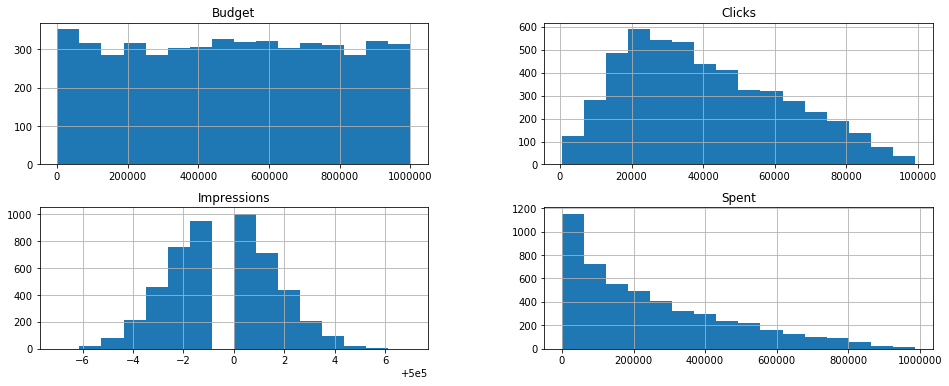

In [29]:
# Graph campaign information
# make another DataFrame made with only these columns
df[['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=16, figsize=(16, 6));


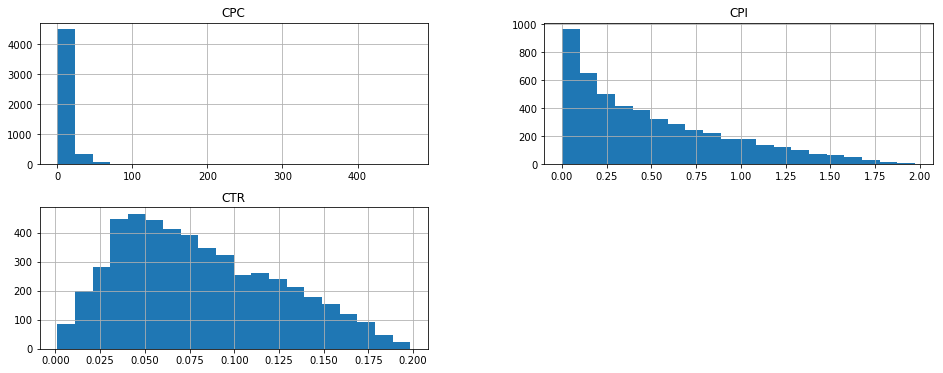

In [30]:
df[['CTR', 'CPC', 'CPI']].hist(
bins=20, figsize=(16, 6));

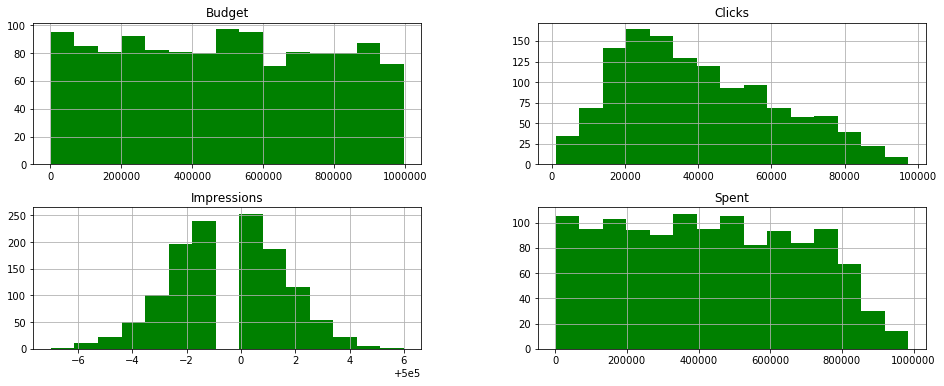

In [32]:
# To explore only a segment of the data apply a MASK to a DataFrame
# Mask to filter out all rows where spent is less than or equal to 75% of the budget
# Keep those where we have spent at least 3/4 of the budget

mask = (df.Spent > 0.75 * df.Budget)

df[mask][['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=15, figsize=(16, 6), color='g');

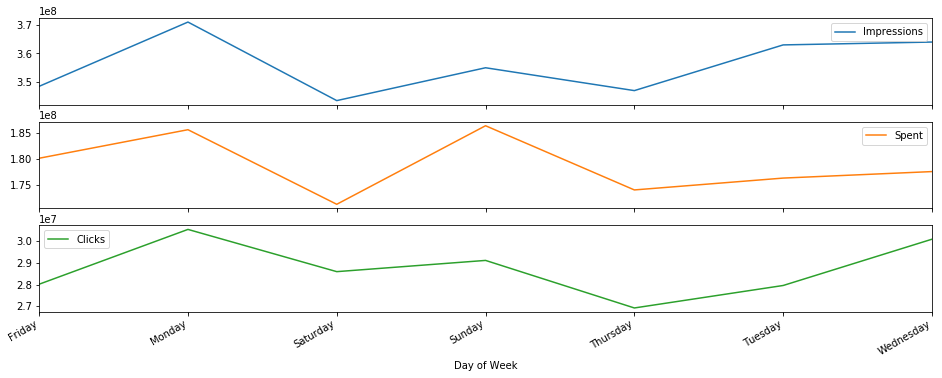

In [34]:
# How about the measure of spent, click, and impressions grouped by day of the week?
df_weekday = df.groupby(['Day of Week']).sum()
df_weekday[['Impressions', 'Spent', 'Clicks']].plot(
    figsize=(16, 6), subplots=True);

### Extra Credit: Create a solution that will keep days of the week in order!

In [35]:
# a simple aggregation. We want to aggregate on 'Target Gender' and 'Target Age', 
# and show 'Impressions' and 'Spent'. For both, we want to see
# the mean and the standard deviation.

agg_config = {
    'Impressions': {
    'Mean Impr': 'mean',
    'Std Impr': 'std',
    },
    'Spent': ['mean', 'std'],
}

df.groupby(['Target Gender', 'Target Age']).agg(agg_config)

G:\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


Impressions                    Spent  \
                              Mean Impr  Std Impr           mean   
Target Gender Target Age                                           
B             20-25       499999.153846  1.822008  235676.276923   
              20-30       499999.604938  1.736944  247967.962963   
              20-35       499999.263158  1.899954  273222.947368   
              20-40       499999.594203  2.060260  322956.492754   
              20-45       499999.809524  2.112322  267053.333333   
              25-30       499999.513158  1.762524  228543.868421   
              25-35       499999.181818  2.029847  254777.272727   
              25-40       499999.246575  2.113323  230521.808219   
              25-45       499999.349206  1.761220  238404.301587   
              25-50       500000.000000  2.476557  174724.312500   
              30-35       499999.585366  2.066495  247310.451220   
              30-40       499999.655556  2.045335  208139.922222   
              30-45       499999.486842  1.996620  278474.381579   
              30-50       499999.485294  2.011108  261517.691176   
              30-55       499999.809524  1.749830  321609.380952   
              35-40       499999.376623  2.294381  245401.142857   
              35-45       499999.653333  1.906556  245188.000000   
              35-50       499999.378049  2.192244  282219.243902   
              35-55       499999.178571  1.939822  274254.630952   
              35-60       499999.000000  2.478479  194593.466667   
              40-45       499999.328947  2.374240  253114.078947   
              40-50       499999.449438  1.895037  249698.797753   
              40-55       499999.829268  2.089390  229767.000000   
              40-60       499999.379310  2.047354  227761.896552   
              40-65       499999.785714  2.259291  300459.714286   
              45-50       499999.812500  2.040221  183339.125000   
              45-55       500000.227273  2.091521  281106.136364   
              45-60       499999.166667  1.823055  295868.333333   
              45-65       500000.050000  2.564433  172698.050000   
F             20-25       499999.714286  1.927248  261162.685714   
...                                 ...       ...            ...   
M             20-25       499999.540541  2.197066  258497.581081   
              20-30       499999.055556  1.985077  285087.763889   
              20-35       499999.554054  1.744988  232754.459459   
              20-40       499999.542169  2.254000  246451.084337   
              20-45       499999.812500  1.796988  198423.312500   
              25-30       499999.546667  2.188998  272300.186667   
              25-35       499999.444444  1.767380  192560.666667   
              25-40       499999.108434  2.147103  236573.180723   
              25-45       499999.527778  2.181692  304898.888889   
              25-50       499999.222222  1.855921  155784.444444   
              30-35       499999.718310  1.782319  229297.633803   
              30-40       499999.481928  2.008284  229419.253012   
              30-45       499999.441558  2.221270  254223.961039   
              30-50       499999.671429  1.847218  234934.657143   
              30-55       499998.083333  1.729862  360844.166667   
              35-40       499999.746988  2.011209  253874.879518   
              35-45       499999.470588  1.651754  199609.235294   
              35-50       499999.657534  1.879858  268430.794521   
              35-55       499999.280488  1.958044  246067.024390   
              35-60       499998.909091  1.221028  303643.272727   
              40-45       499999.647727  2.117469  227880.125000   
              40-50       499999.557143  1.938442  297243.828571   
              40-55       499999.519481  1.984217  230122.779221   
              40-60       499999.671053  2.174937  185139.855263   
              40-65       499999.480000  1.828478  233299.360000   
              45

In [36]:
# Pivot Table
pivot = df.pivot_table(
    values=['Impressions', 'Clicks', 'Spent'],
    index=['Target Age'],
    columns=['Target Gender'],
    aggfunc=np.sum
)

pivot

Clicks                       Impressions              \
Target Gender          B          F          M           B           F   
Target Age                                                               
20-25          2483581.0  2811393.0  2770158.0  32499945.0  34999980.0   
20-30          3439659.0  2150961.0  2810167.0  40499968.0  34999940.0   
20-35          2884294.0  2733431.0  2926107.0  37999944.0  34999960.0   
20-40          2784078.0  3424451.0  3338801.0  34499972.0  39499960.0   
20-45           874407.0   440945.0   675916.0  10499996.0   5499990.0   
25-30          3379732.0  3322305.0  3161370.0  37999963.0  44999925.0   
25-35          2570555.0  2760795.0  3259720.0  32999946.0  32999960.0   
25-40          2644755.0  2894451.0  3140694.0  36499945.0  36499959.0   
25-45          2929140.0  4032440.0  3129103.0  31499959.0  48499965.0   
25-50           651257.0   664190.0   386644.0   8000000.0   7499997.0   
30-35          3258649.0  2876971.0  2969333.0  40999966.0  34499974.0   
30-40          3561359.0  3265499.0  3143815.0  44999969.0  39999959.0   
30-45          3251304.0  3041034.0  3096180.0  37999961.0  38999939.0   
30-50          2672149.0  2481408.0  2771701.0  33999965.0  32499961.0   
30-55           768950.0   458506.0   648662.0  10499996.0   5999990.0   
35-40          3062849.0  3286856.0  3118488.0  38499952.0  36499976.0   
35-45          2829093.0  3196446.0  3628718.0  37499974.0  37499990.0   
35-50          3508323.0  2250551.0  2935365.0  40999949.0  30499965.0   
35-55          3745951.0  3104089.0  3452735.0  41999931.0  37999985.0   
35-60           565262.0   472528.0   493262.0   7499985.0   4999992.0   
40-45          3079868.0  2489959.0  3263238.0  37999949.0  31999990.0   
40-50          3737809.0  2455839.0  2723208.0  44499951.0  30499983.0   
40-55          2935484.0  2916412.0  3062234.0  40999986.0  38999948.0   
40-60          3512515.0  2797081.0  3385303.0  43499946.0  35999974.0   
40-65           585587.0   837886.0  1233641.0   6999997.0   9999996.0   
45-50           493256.0   494675.0   425624.0   7999997.0   5500002.0   
45-55           859388.0   527078.0   960096.0  11000005.0   6500002.0   
45-60           871840.0   529199.0   756966.0   8999985.0   7499987.0   
45-65           749507.0   500636.0   901439.0  10000001.0   7500001.0   
45-70                NaN   216465.0   477805.0         NaN   1999992.0   

                                Spent                          
Target Gender           M           B           F           M  
Target Age                                                     
20-25          36999966.0  15318958.0  18281388.0  19128821.0  
20-30          35999932.0  20085405.0  18062370.0  20526319.0  
20-35          36999967.0  20764944.0  17350532.0  17223830.0  
20-40          41499962.0  22283998.0  24018928.0  20455440.0  
20-45           7999997.0   5608120.0   1802554.0   3174773.0  
25-30          37499966.0  17369334.0  23745647.0  20422514.0  
25-35          35999960.0  16815300.0  15541232.0  13864368.0  
25-40          41499926.0  16828092.0  21146340.0  19635574.0  
25-45          35999966.0  15019471.0  27486432.0  21952720.0  
25-50           4499993.0   2795589.0   3901366.0   1402060.0  
30-35          35499980.0  20279457.0  17343657.0  16280132.0  
30-40          41499957.0  18732593.0  18356914.0  19041798.0  
30-45          38499957.0  21164053.0  22396892.0  19575245.0  
30-50          34999977.0  17783203.0  15257333.0  16445426.0  
30-55           5999977.0   6753797.0   2072492.0   4330130.0  
35-40          41499979.0  18895888.0  20040600.0  21071615.0  
35-45          42499955.0  18389100.0  19262414.0  16966785.0  
35-50          36499975.0  23141978.0  16430639.0  19595448.0  
35-55          40999941.0  23037389.0  19380191.0  20177496.0  
35-60           5499988.0   2918902.0   1902604.0   3340076.0  
40-45          43999969.0  19236670.0  17417714.0  20053451.0  
40-50          34999969.0  22223193.0  